# Regression

In [1]:
### --- Dependencies --- ###
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import datetime
import importlib
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import datetime
import os
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)


# parser = argparse.ArgumentParser(description='PyTorch NTK Uncertainty Estimate Experiment')
# parser.add_argument('--dataset',default='cifar',type=str,help='dataset (cifar or imagenet)')
# args = parser.parse_args()

### --- CONSTANTS --- ###
dataset_str = 'concrete'
TRAIN_RATIO = 0.9
BATCH_SIZE = 100
NORMALIZE_X = True
NORMALIZE_Y = True
LAYER_WIDTH = 150
NTK_WEIGHT_INIT = True

NTK_MODEL_PATH = "./model_chkpt/ntk_network.pt"
ENSEMBLE_MODEL_PATH = "./model_chkpt/ensemble_networks.pt"

ensemble_M = 5

FIND_MAN_KAPPA = False
REPORT_KAPPA = False
FIND_FUNC_JAX_KAPPA = True
KAPPA_COMPARISON = FIND_MAN_KAPPA and FIND_FUNC_JAX_KAPPA

### --- INPUT DATA HERE AS WELL AS DATASET NAME --- ###
if dataset_str == 'energy':
    data = pd.read_excel('.\data\Energy\ENB2012_data.xlsx')
    num_features = 8
elif dataset_str == 'concrete':
    data = pd.read_excel('.\data\Concrete\Concrete_Data.xls')
    num_features = 8

# print(data.shape)
print("--- Loading dataset {} --- \n".format(dataset_str))
print("Number of data points = {}".format(len(data)))
print("Number of coloumns = {}".format(len(data.columns)))
print("Number of features = {}".format(num_features))

training_set, test_set = df.data_split(data,TRAIN_RATIO)

if NORMALIZE_X:
    train_mX = training_set[:,:num_features].mean(axis=0)
    train_sX = training_set[:,:num_features].std(axis=0)
    train_sX[train_sX==0]=1
else:
    train_mX = 0
    train_sX = 1

if NORMALIZE_Y:
    train_my = training_set[:,num_features].mean(axis=0)
    train_sy = training_set[:,num_features].std(axis=0)
    if train_sy==0:
        train_sy=1
else:
    train_my = 0
    train_sy = 1

train_dataset = df.RegressionDataset(training_set, input_dim=num_features, mX=train_mX, sX=train_sX, my=train_my, sy=train_sy)
test_dataset = df.RegressionDataset(test_set, input_dim=num_features, mX=train_mX, sX=train_sX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_set), shuffle=False)

np.set_printoptions(suppress=True, precision=4)
print("\n Sample training point \n X: {}, \n y: {} \n".format(train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]))
print("Sample test point \n X: {}, \n y: {} ".format(test_dataset.__getitem__(0)[0], test_dataset.__getitem__(0)[1]))

--- Loading dataset concrete --- 

Number of data points = 1030
Number of coloumns = 9
Number of features = 8
training set has shape (927, 9) 

test set has shape (103, 9)

 Sample training point 
 X: tensor([-1.2141,  1.2486, -0.8539,  0.5443,  0.4627, -1.2265,  1.1706, -0.2827]), 
 y: -0.7315451263100062 

Sample test point 
 X: tensor([-1.3464,  1.5825, -0.8539,  1.0358, -1.0584, -0.0058, -0.3174,  0.6897]), 
 y: 39.6621069 


In [45]:
from importlib import reload
reload(df)

<module 'definitions' from 'c:\\Users\\s4531973\\Documents\\PhD\\Code\\Uncertainty Quantification\\definitions.py'>

In [9]:
learning_rate = 1e-2
epochs = 4000
train_ensemble = True

## Create Model
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
print("Number of parameters in NTK network = {}".format(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

## Train NTK network
mse_loss = nn.MSELoss(reduction='mean')
ntk_optimizer = df.optimizer_shared(ntk_network, type='adam', learning_rate=learning_rate)
# early_stopper = df.EarlyStopper(patience=50,min_delta=5)
# ntk_scheduler = optim.lr_scheduler.StepLR(ntk_optimizer,epochs/4,gamma=0.1)
# ntk_plateau_sched = optim.lr_scheduler.ReduceLROnPlateau(ntk_optimizer,'min',factor=0.5)
# ntk_scheduler = optim.lr_scheduler.PolynomialLR(ntk_optimizer,total_iters=4000)
# ntk_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     ntk_optimizer,
#     int(epochs/8),
#     eta_min=1e-2
# )

# Run the training loop
print("\n Training NTK network \n")
for epoch in tqdm(range(epochs)):
    ntk_train_mse  = df.training_loop_ntk(
        dataloader=train_loader,
        model=ntk_network, 
        optimizer=ntk_optimizer,
        loss_function=mse_loss,
        verbose=False)
    
    ntk_test_mse, ntk_test_rel_error = df.test_loop_ntk(
        dataloader=test_loader,
        model = ntk_network,
        my=train_my,
        sy=train_sy,
        loss_function=mse_loss)
    
    # ntk_plateau_sched.step(ntk_test_mse)
    # ntk_scheduler.step()

    # if early_stopper.early_stop(ntk_test_mse):
    #     break

    if epoch % int(epochs/4) == 0:
        print("Epoch {} of {}".format(epoch,epochs))
        print("Training MSE = {:.3f}".format(ntk_train_mse))
        print("Test MSE = {:.2f}".format(ntk_test_mse))
        # print("Learning rate = {}".format(ntk_scheduler.get_last_lr()))
    
# Process is complete.
print('\n NTK Training process has finished.')
print("Final training MSE = {:.3f}".format(ntk_train_mse))
print("Final test MSE = {:.2f}".format(ntk_test_mse))
print("Final epoch = {}".format(epoch))

torch.save({
    'model': ntk_network.state_dict(),
    'train_mse': ntk_train_mse,
    'test_mse': ntk_test_mse,
    'test_rel_err': ntk_test_rel_error
    },
    NTK_MODEL_PATH)

## 

ensemble_model_list = []
ensemble_model_state_list = []
ensemble_opt_list = []
ensemble_sched_list = []
ensemble_mse_training_list = np.empty(ensemble_M)
ensemble_mse_test_list = np.empty(ensemble_M)
ensemble_nll_list = np.empty(ensemble_M)
ensemble_rel_err_test_list = np.empty((ensemble_M,len(test_dataset)))

NLL = df.CustomNLL()
for i in range(ensemble_M):
    ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_opt_list.append(df.optimizer_shared(ensemble_model_list[i], type='adam', learning_rate=learning_rate))
    ensemble_sched_list.append(optim.lr_scheduler.StepLR(ensemble_opt_list[i],epochs/4,gamma=0.5))

for i in range(ensemble_M):
    print(f"\n Training ensemble {i+1} ")
    for epoch in tqdm(range(epochs)):
        ensemble_train_mse = df.training_loop_ensemble(
            dataloader=train_loader, 
            model=ensemble_model_list[i], 
            optimizer=ensemble_opt_list[i], 
            loss_function=NLL,
            mse_loss= mse_loss,
            verbose=False)
        
        ensemble_test_mse, ensemble_test_nll, ensemble_test_rel_err = df.test_loop_ensemble(
            dataloader=test_loader, 
            model=ensemble_model_list[i], 
            my=train_my, 
            sy=train_sy, 
            mse_loss=mse_loss,
            loss_function=NLL)
        
        ensemble_sched_list[i].step()
        
        if epoch % (epochs/4) == 0:
            print("Epoch {} of {}".format(epoch,epochs))
            print("Training MSE = {:.3f}".format(ensemble_train_mse))
            print("Test MSE = {:.2f}".format(ensemble_test_mse))
            print("Learning rate = {}".format(ensemble_sched_list[i].get_last_lr()))

    print("Done!")
    ensemble_mse_training_list[i] = ensemble_train_mse
    ensemble_mse_test_list[i] = ensemble_test_mse
    ensemble_nll_list[i] = ensemble_test_nll
    ensemble_rel_err_test_list[i,:] = ensemble_test_rel_err.detach().numpy().squeeze(1)
print('\n Ensemble training process has finished.')

## Print training metrics
print("Final ntk training MSE = {:.4f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

for i in range(ensemble_M):
    ensemble_model_state_list.append(ensemble_model_list[i].state_dict())

torch.save({
    'models': ensemble_model_state_list,
    'train_mse': ensemble_mse_training_list,
    'test_mse': ensemble_mse_test_list,
    'test_nll': ensemble_nll_list,
    'test_rel_err': ensemble_rel_err_test_list
    },
    ENSEMBLE_MODEL_PATH)

print("Model saved!")

Using cpu device
Number of parameters in NTK network = 92101

 Training NTK network 



  0%|          | 3/4000 [00:00<03:03, 21.83it/s]

Epoch 0 of 4000
Training MSE = 1.368
Test MSE = 240.15


 25%|██▌       | 1002/4000 [00:46<03:04, 16.28it/s]

Epoch 1000 of 4000
Training MSE = 0.016
Test MSE = 13.88


 50%|█████     | 2004/4000 [01:52<02:15, 14.77it/s]

Epoch 2000 of 4000
Training MSE = 0.017
Test MSE = 13.53


 75%|███████▌  | 3002/4000 [03:02<01:12, 13.74it/s]

Epoch 3000 of 4000
Training MSE = 0.007
Test MSE = 13.85


100%|██████████| 4000/4000 [04:13<00:00, 15.80it/s]



 NTK Training process has finished.
Final training MSE = 0.006
Final test MSE = 13.91
Final epoch = 3999

 Training ensemble 1 


  0%|          | 3/4000 [00:00<02:44, 24.27it/s]

Epoch 0 of 4000
Training MSE = 0.706
Test MSE = 117.22
Learning rate = [0.01]


 25%|██▌       | 1004/4000 [00:35<01:57, 25.54it/s]

Epoch 1000 of 4000
Training MSE = 0.035
Test MSE = 23.26
Learning rate = [0.005]


 50%|█████     | 2003/4000 [01:16<01:22, 24.34it/s]

Epoch 2000 of 4000
Training MSE = 0.016
Test MSE = 15.31
Learning rate = [0.0025]


 75%|███████▌  | 3005/4000 [01:58<00:40, 24.52it/s]

Epoch 3000 of 4000
Training MSE = 0.007
Test MSE = 13.29
Learning rate = [0.00125]


100%|██████████| 4000/4000 [02:39<00:00, 25.05it/s]


Done!

 Training ensemble 2 


  0%|          | 6/4000 [00:00<02:21, 28.30it/s]

Epoch 0 of 4000
Training MSE = 0.847
Test MSE = 111.31
Learning rate = [0.01]


 25%|██▌       | 1003/4000 [00:35<01:55, 25.86it/s]

Epoch 1000 of 4000
Training MSE = 0.023
Test MSE = 24.40
Learning rate = [0.005]


 50%|█████     | 2005/4000 [01:15<01:19, 25.18it/s]

Epoch 2000 of 4000
Training MSE = 0.047
Test MSE = 26.19
Learning rate = [0.0025]


 75%|███████▌  | 3004/4000 [01:56<00:40, 24.70it/s]

Epoch 3000 of 4000
Training MSE = 0.062
Test MSE = 36.54
Learning rate = [0.00125]


100%|██████████| 4000/4000 [02:37<00:00, 25.42it/s]


Done!

 Training ensemble 3 


  0%|          | 3/4000 [00:00<02:25, 27.47it/s]

Epoch 0 of 4000
Training MSE = 0.701
Test MSE = 175.28
Learning rate = [0.01]


 25%|██▌       | 1006/4000 [00:35<02:00, 24.75it/s]

Epoch 1000 of 4000
Training MSE = 0.033
Test MSE = 21.57
Learning rate = [0.005]


 50%|█████     | 2005/4000 [01:16<01:22, 24.13it/s]

Epoch 2000 of 4000
Training MSE = 0.033
Test MSE = 28.20
Learning rate = [0.0025]


 75%|███████▌  | 3004/4000 [01:57<00:41, 23.96it/s]

Epoch 3000 of 4000
Training MSE = 0.011
Test MSE = 17.95
Learning rate = [0.00125]


100%|██████████| 4000/4000 [02:38<00:00, 25.20it/s]


Done!

 Training ensemble 4 


  0%|          | 3/4000 [00:00<02:24, 27.69it/s]

Epoch 0 of 4000
Training MSE = 0.749
Test MSE = 126.74
Learning rate = [0.01]


 25%|██▌       | 1004/4000 [00:36<02:02, 24.44it/s]

Epoch 1000 of 4000
Training MSE = 0.027
Test MSE = 20.56
Learning rate = [0.005]


 50%|█████     | 2006/4000 [01:18<01:22, 24.21it/s]

Epoch 2000 of 4000
Training MSE = 0.017
Test MSE = 14.45
Learning rate = [0.0025]


 75%|███████▌  | 3005/4000 [01:59<00:41, 23.83it/s]

Epoch 3000 of 4000
Training MSE = 0.012
Test MSE = 19.03
Learning rate = [0.00125]


100%|██████████| 4000/4000 [02:39<00:00, 25.00it/s]


Done!

 Training ensemble 5 


  0%|          | 3/4000 [00:00<02:21, 28.16it/s]

Epoch 0 of 4000
Training MSE = 0.708
Test MSE = 129.64
Learning rate = [0.01]


 25%|██▌       | 1005/4000 [00:35<01:57, 25.58it/s]

Epoch 1000 of 4000
Training MSE = 0.021
Test MSE = 20.23
Learning rate = [0.005]


 50%|█████     | 2004/4000 [01:15<01:19, 25.12it/s]

Epoch 2000 of 4000
Training MSE = 0.008
Test MSE = 12.12
Learning rate = [0.0025]


 75%|███████▌  | 3006/4000 [01:55<00:39, 25.03it/s]

Epoch 3000 of 4000
Training MSE = 0.013
Test MSE = 19.72
Learning rate = [0.00125]


100%|██████████| 4000/4000 [02:36<00:00, 25.63it/s]

Done!

 Ensemble training process has finished.
Final ntk training MSE = 0.0061
Final ntk test MSE = 13.91
Final ensemble training MSE = [0.0085 0.024  0.0082 0.0207 0.0069]
Final ensemble test MSE = [12.1334 27.7479 17.825  21.99   18.8367]
Model saved!


Using cpu device
Loading models:
Models loaded.


C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o


 --- Finding uncertainty estimates --- 

Norm of residual array (y-f) = 2.2411588500322015
Norm of resid_solve = 46542.925714868856


100%|██████████| 103/103 [00:18<00:00,  5.54it/s]


Finished! 

Number of zero values uncertainty array: 0
Number of negative values for full rank: 0

 --- Plotting Results --- 



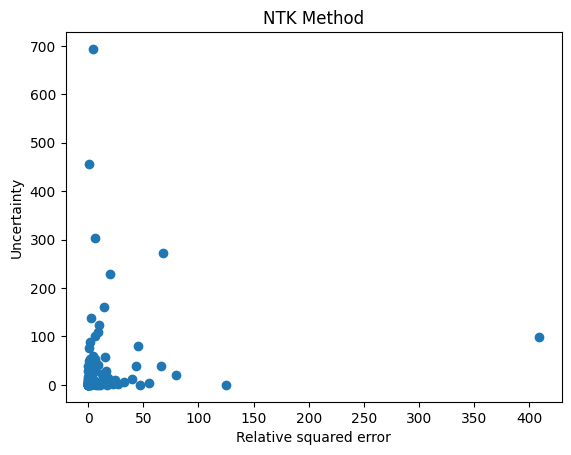

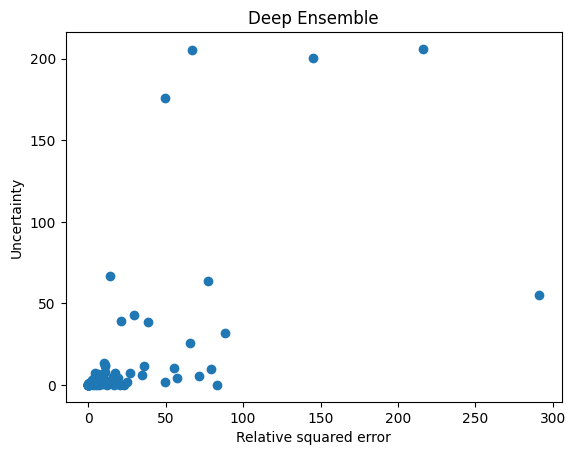

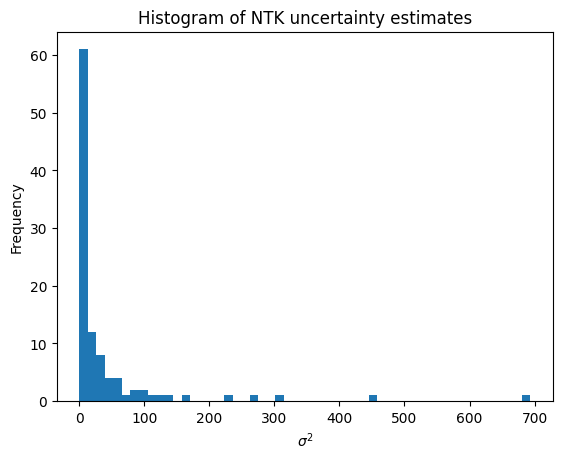

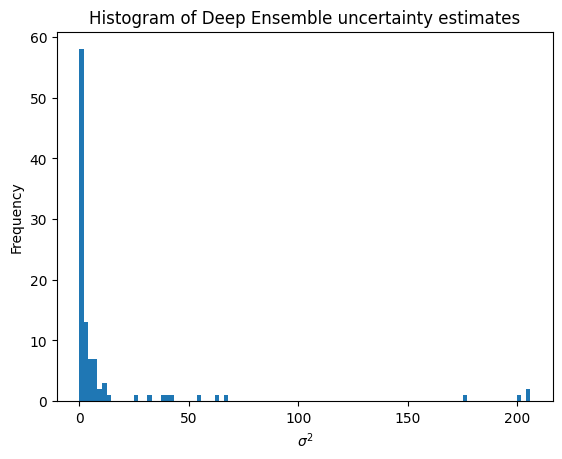

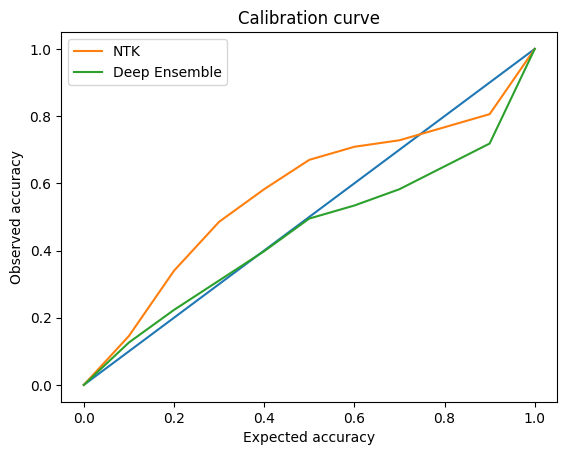

Final ntk training MSE = 0.006
Final ntk test MSE = 13.91
Final ensemble training MSE = [0.0085 0.024  0.0082 0.0207 0.0069]
Final ensemble test MSE = [12.1334 27.7479 17.825  21.99   18.8367]


In [10]:
type_solve = 'iterative'
rtol_solve = 1e-9
maxit_solve = 2000

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## load models
print("Loading models:")

# Load NTK Model
ntk_saved_model = torch.load(NTK_MODEL_PATH)

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
ntk_network.load_state_dict(ntk_saved_model['model'])
ntk_network.eval()

ntk_train_mse = ntk_saved_model['train_mse']
ntk_test_mse = ntk_saved_model['test_mse']
ntk_test_rel_error = ntk_saved_model['test_rel_err']

# Load Ensemble Models
ensemble_saved_models = torch.load(ENSEMBLE_MODEL_PATH)

ensemble_model_list = []
for i in range(ensemble_M):
    ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_model_list[i].load_state_dict(ensemble_saved_models['models'][i])
    ensemble_model_list[i].eval()

ensemble_mse_training_list = ensemble_saved_models['train_mse']
ensemble_mse_test_list = ensemble_saved_models['test_mse']
ensemble_nll_list = ensemble_saved_models['test_nll']
ensemble_rel_err_test_list = ensemble_saved_models['test_rel_err']

print("Models loaded.")

### --- NTK --- ###
if FIND_MAN_KAPPA:
    EPSILON = 0
    print("\n --- Finding Kappa --- \n")
    kappa_man_time_start = time.time()
    Kappa_man = df.ntk_matrix(train_dataset,train_dataset,model=ntk_network,optimizer=ntk_optimizer)
    kappa_man_time_end = time.time()
    kappa_man_time = kappa_man_time_end - kappa_man_time_start
    eigvals = np.linalg.eigvalsh(Kappa_man)

if FIND_FUNC_JAX_KAPPA:
    kappa_jax_time_start = time.time()
    Kappa = df.empirical_ntk(
        model=ntk_network,
        dataset1=train_dataset,
        dataset2=train_dataset
    )
    Kappa_jax = Kappa.detach().numpy().squeeze((2,3))
    kappa_jax_time_end = time.time()
    kappa_jax_time = kappa_jax_time_end - kappa_jax_time_start
    eigvals = np.linalg.eigvalsh(Kappa_jax)

if REPORT_KAPPA:
    print("\n--- Kappa (Manual) Summary --- \n")
    print("Condition number of Kappa = {:.2f}".format(np.linalg.cond(Kappa)))
    eigvals = np.linalg.eigvalsh(Kappa)
    print("Number of negative eigenvalues of Kappa = {}".format(eigvals[eigvals<0].size))
    print("Number of zero eigenvalues of Kappa = {}".format(eigvals[eigvals==0].size))
    print("Smallest eigenvalue is = {}".format(sorted(eigvals)[0]))

if KAPPA_COMPARISON:

    man_eigvals = np.linalg.eigvalsh(Kappa_man)
    jax_eigvals = np.linalg.eigvalsh(Kappa_jax)

    plot_dir = "./ntk_conditioning_results/"
    results_name = "results.txt"
    with open(plot_dir+results_name,'w') as results:
        results.write("{} \n".format(datetime.datetime.now()))
        results.write("Manual method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {}, \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_man_time,
                                                     np.linalg.cond(Kappa_man),
                                                        man_eigvals[man_eigvals<0].size,
                                                        sorted(man_eigvals)[0])
        )
        results.write("\n PyTorch JAX method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {} \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_jax_time,
                                                     np.linalg.cond(Kappa_jax),
                                                        jax_eigvals[jax_eigvals<0].size,
                                                        sorted(jax_eigvals)[0])
        )
        results.write("Frobenius norm difference between two methods = {}".format(
            np.linalg.norm(Kappa_man-Kappa_jax)
        ))

### --- Current Kappa --- ###
        
Kappa = Kappa_jax

## Uncertainty Quantification
print("\n --- Finding uncertainty estimates --- \n")
uncert_time_start = time.time()
uncertainty_array, solver_info, uncertainty_array_lifted, mu = df.ntk_uncertainty_explicit(
    Kappa=Kappa, 
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=ntk_network,
    type=type_solve,
    rtol=rtol_solve,
    maxit=maxit_solve)
uncert_time_end = time.time()
uncert_time = uncert_time_end-uncert_time_start # (seconds)
solver_info_mean = np.mean(solver_info,axis=1)
print("Finished! \n")
print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))

# uncertainty_array = uncertainty_array / np.sqrt(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad))
# uncertainty_array[(uncertainty_array*(train_sy**2))>1000] = 0.1

mu_mean, sigma_mean = df.ensemble_result(
    test_loader=test_loader,
    ensemble_M=ensemble_M,
    model_list=ensemble_model_list,
    sy=train_sy,
    my=train_my
)
ensemble_rel_err_test_list = np.mean(ensemble_rel_err_test_list,axis=0)

### --- Plot results --- ###
param_ntk = sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)

print("\n --- Plotting Results --- \n")
today = datetime.date.today()
now = datetime.datetime.now()
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, today.strftime("%d_%m_%Y"))
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
plot_dir = "./data/{}/early_stop_p_2_{}/plot/".format(dataset_str,param_ntk)
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

## NTK Scatter
plot_name = "ntk_scatter.pdf"
plt.scatter(ntk_test_rel_error, uncertainty_array*(train_sy**2))
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("NTK Method")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Scatter
# plot_name = "ntk_lifted_scatter.pdf"
# plt.scatter(ntk_test_rel_error, uncertainty_array_lifted*(train_sy**2))
# plt.xlabel("Relative squared error")
# plt.ylabel("Uncertainty")
# plt.title("NTK Lifted Method")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble scatter
plot_name = "ensemble_scatter.pdf"
plt.scatter(ensemble_rel_err_test_list, sigma_mean)
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("Deep Ensemble")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## NTK Histogram
plot_name = "ntk_hist.pdf"
plt.hist(sorted((train_sy**2)*uncertainty_array.squeeze(0)), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of NTK uncertainty estimates")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Histogram
# plot_name = "ntk_lifted_hist.pdf"
# plt.hist(sorted((train_sy**2)*uncertainty_array_lifted.squeeze(0)), bins='auto')
# plt.xlabel("$\sigma^2$")
# plt.ylabel("Frequency")
# plt.title("Histogram of NTK Lifted uncertainty estimates")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble Histogram
plot_name = "ensemble_hist.pdf"
plt.hist(sorted(sigma_mean), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of Deep Ensemble uncertainty estimates")
plt.savefig(plot_dir + plot_name.format(dataset_str), format="pdf", bbox_inches="tight")
plt.show()

### --- Plot calibration curve --- ###

plot_name = "calibration_curve.pdf"
observed_true_ntk = df.calibration_curve_ntk(
    testloader=test_loader, 
    uncertainties=uncertainty_array, 
    model=ntk_network, 
    num_c=11, 
    my=train_my, 
    sy=train_sy)
observed_true_ensemble = df.calibration_curve_ensemble(
    testloader=test_loader, 
    mu=mu_mean, 
    sigma2=sigma_mean, 
    num_c=11)
df.plot_calibration(
    observed_true_ntk=observed_true_ntk, 
    observed_true_ensemble=observed_true_ensemble, 
    dataset_str=dataset_str, 
    dir_name=plot_dir, 
    plot_name=plot_name)

# ### --- Plot calibration curve (lifted) --- ###

# plot_name = "calibration_curve_lifted.pdf"
# observed_true_ntk = df.calibration_curve_ntk(
#     testloader=test_loader, 
#     uncertainties=uncertainty_array_lifted, 
#     model=ntk_network, 
#     num_c=11, 
#     my=train_my, 
#     sy=train_sy)
# observed_true_ensemble = df.calibration_curve_ensemble(
#     testloader=test_loader, 
#     mu=mu_mean, 
#     sigma2=sigma_mean, 
#     num_c=11)
# df.plot_calibration(
#     observed_true_ntk=observed_true_ntk, 
#     observed_true_ensemble=observed_true_ensemble, 
#     dataset_str=dataset_str, 
#     dir_name=plot_dir, 
#     plot_name=plot_name)

# result_dir = "./data/{}/{}/result/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
result_dir = "./data/{}/early_stop_p_2_{}/result/".format(dataset_str,param_ntk)
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

print("Final ntk training MSE = {:.3f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

results_name = "results.txt"
with open(result_dir+results_name,'w') as results:
    results.write("--- Dataset & Model --- \n")
    results.write("Number of training points = {} \n".format(len(training_set)))
    results.write("Number of test points = {} \n".format(len(test_set)))
    results.write("Number of features = {} \n".format(num_features))
    results.write("Number of hidden layers = {} \n".format(3))
    results.write("Width of hidden layer = {} \n".format(LAYER_WIDTH))
    results.write("Number of parameters in NTK network = {} \n".format(
        sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

    results.write("\n --- Results --- \n")
    results.write("Final ntk training mse = {:.3f} \n".format(ntk_train_mse))
    results.write("Final ntk test mse = {:.2f} \n".format(ntk_test_mse))
    results.write("Deep Ensemble training mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_training_list),np.std(ensemble_mse_training_list)))
    results.write("Deep Ensemble test mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_test_list),np.std(ensemble_mse_test_list)))
    results.write("Deep Ensemble NLL: mean = {:.2f}, std {:.2f} \n".format(np.mean(ensemble_nll_list),np.std(ensemble_nll_list)))
    results.write("\n --- Training Details --- \n")
    results.write("Learning Rate = {} \n".format(learning_rate))
    results.write("Training Epochs = {} \n".format(epochs))
    results.write("Number of ensembles = {} \n".format(ensemble_M))

    results.write("\n --- NTK Method Details --- \n")
    results.write("Condition number of Kappa = {:.2f} \n".format(np.linalg.cond(Kappa)))
    results.write("Number of negative eigenvalues of Kappa = {} \n".format(eigvals[eigvals<0].size))
    results.write("Number of zero eigenvalues of Kappa = {} \n".format(eigvals[eigvals==0].size))

    results.write("\n --- Uncertainty Solution Details --- \n")
    results.write("Type of linear solver = {} \n".format(type_solve))
    if type_solve=='iterative':
        results.write("Time to solve all test examples = {:.2f} seconds \n".format(uncert_time))
        results.write("Tolerance of solver = {} \n".format(rtol_solve))
        results.write("Max iteration of solver = {} \n".format(maxit_solve))
        results.write("Average solver iter = {} \n".format(solver_info_mean[0]))
        results.write("Average solver resid error = {} \n".format(solver_info_mean[1]))
        results.write("Average solver matrix resid error = {} \n".format(solver_info_mean[2]))
    results.write("\n Number of negative values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array<0].size))
    results.write("Number of zero values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array==0].size))


In [4]:
test_dataloader = DataLoader(test_dataset,len(test_dataset))
X_test,y_test = next(iter(test_dataloader))
x_hat = ntk_network(X_test)

In [8]:
mu_t = torch.from_numpy(mu).reshape(-1,1)
x_hat = x_hat
y_test = y_test.reshape(-1,1)
print("Sizes are {},{},{}".format(mu_t.shape,x_hat.shape,y_test.shape))
mse_loss = nn.MSELoss(reduction='mean')
print("MSE loss from model = {}".format(mse_loss(x_hat*train_sy+train_my,y_test)))
print("MSE loss from ntk mean = {}".format(mse_loss(mu_t*train_sy+train_my,y_test)))
print("Norm difference between ntk mean and model pred = {}".format(torch.norm(mu_t-x_hat)))
# print(mu_t*train_sy+train_my)
# print(x_hat*train_sy+train_my)


Sizes are torch.Size([103, 1]),torch.Size([103, 1]),torch.Size([103, 1])
MSE loss from model = 18.30758420922314
MSE loss from ntk mean = 756.6575746895506
Norm difference between ntk mean and model pred = 16.427187756919864


# Classification

In [1]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from tqdm import tqdm
import definitions as df
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import importlib
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)

N_TRAIN = 1000
N_TEST = 100
N_OUTPUT = 10
learning_rate = 1e-1
batch_size = 50
epochs = 50

training_data = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data = torch.utils.data.Subset(training_data,range(N_TRAIN))
test_data = torch.utils.data.Subset(test_data,range(N_TEST))
 
cnn = df.CNN()
print("Number of parameters p = {}".format(sum(p.numel() for p in cnn.parameters() if p.requires_grad)))

train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, N_TEST)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):
    cnn_train_ce = df.train_loop(train_dataloader, cnn, loss_fn, optimizer)
    cnn_test_ce, cnn_test_acc = df.test_loop(test_dataloader, cnn, loss_fn)
    if epoch % int(epochs/50) == 0:
        print("Epoch {} of {}".format(epoch,epochs))
        print("Training CE = {:.3f}".format(cnn_train_ce))
        print("Test CE = {:.2f}".format(cnn_test_ce))
        print("Test accuracy = {:.1f}%".format(100*cnn_test_acc))
print("Done!")
print("Final cnn training cross-entropy = {:.3f}".format(cnn_train_ce))
print("Final cnn test cross-entropy = {:.2f}".format(cnn_test_ce))
print("Final cnn test accuracy = {:.1f}%".format(100*cnn_test_acc))

ensemble_M = 5

ensemble_model_list = []
ensemble_opt_list = []
ensemble_ce_training_list = np.empty(ensemble_M)
ensemble_ce_test_list = np.empty(ensemble_M)
ensemble_ce_acc_list = np.empty(ensemble_M)


for i in range(ensemble_M):
    ensemble_model_list.append(df.CNN())
    ensemble_opt_list.append(torch.optim.SGD(ensemble_model_list[i].parameters(), lr=learning_rate))

for i in range(ensemble_M):
    print(f"\n Training ensemble {i+1} ")
    for epoch in tqdm(range(epochs)):
        cnn_train_ce = df.train_loop(train_dataloader, ensemble_model_list[i], loss_fn, ensemble_opt_list[i])
        cnn_test_ce, cnn_test_acc = df.test_loop(test_dataloader, ensemble_model_list[i], loss_fn)
        if epoch % int(epochs/5) == 0:
            print("Epoch {} of {}".format(epoch,epochs))
            print("Training CE = {:.3f}".format(cnn_train_ce))
            print("Test CE = {:.2f}".format(cnn_test_ce))
            print("Test accuracy = {:.1f}%".format(100*cnn_test_acc))
    print("Done!")
    print("Final cnn training cross-entropy = {:.3f}".format(cnn_train_ce))
    print("Final cnn test cross-entropy = {:.2f}".format(cnn_test_ce))
    print("Final cnn test accuracy = {:.1f}%".format(100*cnn_test_acc))
    ensemble_ce_training_list[i] = cnn_train_ce
    ensemble_ce_test_list[i] = cnn_test_ce
    ensemble_ce_acc_list[i] = cnn_test_acc
print('\n Ensemble training process has finished.')


Number of parameters p = 1301


  2%|▏         | 1/50 [00:00<00:13,  3.69it/s]

Epoch 0 of 50
Training CE = 2.300
Test CE = 2.29
Test accuracy = 16.0%


  4%|▍         | 2/50 [00:00<00:12,  3.77it/s]

Epoch 1 of 50
Training CE = 2.275
Test CE = 2.24
Test accuracy = 30.0%


  6%|▌         | 3/50 [00:00<00:11,  3.92it/s]

Epoch 2 of 50
Training CE = 2.176
Test CE = 1.99
Test accuracy = 37.0%
Epoch 3 of 50
Training CE = 1.582
Test CE = 1.21
Test accuracy = 55.0%


 10%|█         | 5/50 [00:01<00:10,  4.25it/s]

Epoch 4 of 50
Training CE = 0.993
Test CE = 0.91
Test accuracy = 66.0%


 12%|█▏        | 6/50 [00:01<00:09,  4.41it/s]

Epoch 5 of 50
Training CE = 0.724
Test CE = 0.68
Test accuracy = 74.0%
Epoch 6 of 50
Training CE = 0.571
Test CE = 0.52
Test accuracy = 82.0%


 18%|█▊        | 9/50 [00:02<00:08,  4.87it/s]

Epoch 7 of 50
Training CE = 0.480
Test CE = 0.43
Test accuracy = 85.0%
Epoch 8 of 50
Training CE = 0.413
Test CE = 0.37
Test accuracy = 87.0%


 22%|██▏       | 11/50 [00:02<00:07,  4.92it/s]

Epoch 9 of 50
Training CE = 0.363
Test CE = 0.35
Test accuracy = 87.0%
Epoch 10 of 50
Training CE = 0.327
Test CE = 0.32
Test accuracy = 89.0%


 24%|██▍       | 12/50 [00:02<00:07,  4.97it/s]

Epoch 11 of 50
Training CE = 0.299
Test CE = 0.31
Test accuracy = 89.0%
Epoch 12 of 50
Training CE = 0.277
Test CE = 0.29
Test accuracy = 90.0%


 28%|██▊       | 14/50 [00:03<00:07,  4.95it/s]

Epoch 13 of 50
Training CE = 0.257
Test CE = 0.28
Test accuracy = 90.0%


 32%|███▏      | 16/50 [00:03<00:06,  4.86it/s]

Epoch 14 of 50
Training CE = 0.241
Test CE = 0.27
Test accuracy = 91.0%
Epoch 15 of 50
Training CE = 0.227
Test CE = 0.26
Test accuracy = 91.0%


 34%|███▍      | 17/50 [00:03<00:06,  4.90it/s]

Epoch 16 of 50
Training CE = 0.214
Test CE = 0.25
Test accuracy = 92.0%
Epoch 17 of 50
Training CE = 0.203
Test CE = 0.24
Test accuracy = 92.0%


 38%|███▊      | 19/50 [00:04<00:06,  4.94it/s]

Epoch 18 of 50
Training CE = 0.193
Test CE = 0.23
Test accuracy = 92.0%


 40%|████      | 20/50 [00:04<00:06,  4.70it/s]

Epoch 19 of 50
Training CE = 0.183
Test CE = 0.23
Test accuracy = 92.0%


 42%|████▏     | 21/50 [00:04<00:06,  4.47it/s]

Epoch 20 of 50
Training CE = 0.175
Test CE = 0.22
Test accuracy = 92.0%


 46%|████▌     | 23/50 [00:04<00:05,  4.80it/s]

Epoch 21 of 50
Training CE = 0.167
Test CE = 0.22
Test accuracy = 92.0%
Epoch 22 of 50
Training CE = 0.159
Test CE = 0.22
Test accuracy = 92.0%


 50%|█████     | 25/50 [00:05<00:05,  4.83it/s]

Epoch 23 of 50
Training CE = 0.151
Test CE = 0.21
Test accuracy = 92.0%
Epoch 24 of 50
Training CE = 0.142
Test CE = 0.21
Test accuracy = 91.0%


 52%|█████▏    | 26/50 [00:05<00:04,  4.81it/s]

Epoch 25 of 50
Training CE = 0.135
Test CE = 0.20
Test accuracy = 92.0%
Epoch 26 of 50
Training CE = 0.129
Test CE = 0.20
Test accuracy = 92.0%


 58%|█████▊    | 29/50 [00:06<00:04,  4.99it/s]

Epoch 27 of 50
Training CE = 0.122
Test CE = 0.19
Test accuracy = 94.0%
Epoch 28 of 50
Training CE = 0.117
Test CE = 0.19
Test accuracy = 94.0%


 60%|██████    | 30/50 [00:06<00:04,  4.96it/s]

Epoch 29 of 50
Training CE = 0.110
Test CE = 0.19
Test accuracy = 94.0%


 62%|██████▏   | 31/50 [00:06<00:03,  4.81it/s]

Epoch 30 of 50
Training CE = 0.105
Test CE = 0.18
Test accuracy = 93.0%


 64%|██████▍   | 32/50 [00:06<00:03,  4.70it/s]

Epoch 31 of 50
Training CE = 0.100
Test CE = 0.18
Test accuracy = 93.0%


 68%|██████▊   | 34/50 [00:07<00:03,  4.76it/s]

Epoch 32 of 50
Training CE = 0.095
Test CE = 0.19
Test accuracy = 93.0%
Epoch 33 of 50
Training CE = 0.091
Test CE = 0.18
Test accuracy = 94.0%


 70%|███████   | 35/50 [00:07<00:03,  4.65it/s]

Epoch 34 of 50
Training CE = 0.087
Test CE = 0.18
Test accuracy = 94.0%


KeyboardInterrupt: 

In [90]:
from functorch import make_functional
reload(df)

fnet, params = make_functional(cnn)     

def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)[1].reshape(1)

dataset1_ntk = DataLoader(training_data,len(training_data))
x1_ntk,_ = next(iter(dataset1_ntk))
dataset1_single = DataLoader(training_data,1)
x1_single,_ = next(iter(dataset1_single))
dataset2_ntk = DataLoader(training_data,len(training_data))
x2_ntk,_ = next(iter(dataset2_ntk))
test_dataloader = DataLoader(test_data,len(test_data))
x1_test,_ = next(iter(test_dataloader))

# print("Test shape is {}".format(x1_test.shape))
for x1_single in x1_ntk:
    y = fnet_single(params,x1_single)
print("fnet shape is {}".format(y.shape))
print("fnet is {}".format(y))

# # Kappa_c = df.empirical_ntk_jacobian_contraction_c(fnet_single, params, x1_ntk, x2_ntk,c=1)
Kappa = df.empirical_ntk_jacobian_contraction(fnet_single, params, x1_ntk, x2_ntk)
# # kappa_xx = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x1_test,c=0)
# # kappa_xX_c = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk,c=0)
kappa_xX = df.empirical_ntk_jacobian_contraction(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk)
print(Kappa.shape)
print(kappa_xX.shape)
# # print(kappa_xx.shape)
# # print(kappa_xX.shape)

fnet shape is torch.Size([1])
fnet is tensor([0.2641], grad_fn=<ReshapeAliasBackward0>)
torch.Size([1000, 1000, 1, 1])
torch.Size([100, 1000, 1, 1])


In [16]:
print(torch.norm(kappa_xX[:,:,0,0]-kappa_xX_c))

tensor(6.7744e-12, grad_fn=<LinalgVectorNormBackward0>)


In [2]:
reload(df)

rtol_solve = 1e-5
maxit_solve = 50

uncertainty_array = df.ntk_uncertainty_explicit_class(
    train_dataset=training_data,
    test_dataset=test_data,
    model=cnn,
    num_classes=10,
    type='iterative',
    rtol=rtol_solve,
    maxit=maxit_solve)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 a

In [30]:
import scipy
np.set_printoptions(suppress=True, precision=8)
test_dataloader = DataLoader(test_data,len(test_data))
X_test,_ = next(iter(test_dataloader))
mean = cnn(X_test).detach().numpy().transpose()
n = uncertainty_array[uncertainty_array<0].size
print("Number of negative sigma^2 values = {}".format(n))
print("Mean shape is {}".format(mean.shape))
print("Uncertainty shape is {}".format(uncertainty_array.shape))
probit_approx = df.general_probit_approx(mean,uncertainty_array)
print(scipy.special.softmax(mean[:,1]))
# print(probit_approx[:,1])
# print(uncertainty_array[:,1])
print(scipy.special.softmax(probit_approx[:,1]))
ensemble_mean = np.empty((10,ensemble_M))
for i in range(ensemble_M):
    ensemble_mean[:,i] = ensemble_model_list[i](X_test).detach().numpy().transpose()[:,0]
print(scipy.special.softmax(np.mean(ensemble_mean,axis=1)))

Number of negative sigma^2 values = 0
Mean shape is (10, 100)
Uncertainty shape is (10, 100)
[0.00050003 0.03312013 0.96602234 0.00000002 0.         0.
 0.00035747 0.         0.00000001 0.        ]
[0.07477791 0.18413325 0.60342894 0.01018522 0.00211324 0.0009437
 0.11075764 0.00000091 0.01007075 0.00358844]
[0.         0.         0.         0.00000014 0.         0.
 0.         0.99999986 0.         0.        ]


In [18]:
dataset = DataLoader(training_data,len(training_data))
x,y = next(iter(dataset))
print(x.shape)
print(y.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [ ]:
ood_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)
ood_test_point = ood_data.__getitem__(1)
ood_uncertainty_array=ntk_uncertainty_classification_single(training_data,ood_test_point[0],model=cnn,optimizer=optimizer,num_c=10,mode='max')
test_point = test_data.__getitem__(1)[0]
uncertainty_array=ntk_uncertainty_classification_single(training_data,test_point,model=cnn,optimizer=optimizer,num_c=10,mode='max')
print(uncertainty_array)
print(ood_uncertainty_array)
print(torch.argmax(cnn(ood_test_point[0])).item())
print(ood_test_point[1])

In [4]:
x = torch.ones((4,4,4,4))
print(x[:,:,1,1].shape)

torch.Size([4, 4])
